<a href="https://colab.research.google.com/github/hungpham13/ocr-training/blob/main/draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
import os
from utils import *

page = 1
url = f"http://ocr.iguidevietnam.com/processes/2e096e71-8b8b-4f54-2178-08dc3b63fec5/items?status=done&page={page}&size=10"

response = requests.get(url)
response = response.json()
print(response['totalItems'])
# print(response)
annotation_data = []
if not os.path.exists('data'):
    os.mkdir('data')
if not os.path.exists('data/imgs'):
    os.mkdir('data/imgs')

for page in range (1, response['totalPages']+1):
# for page in range (1,2):
    url = f"http://ocr.iguidevietnam.com/processes/2e096e71-8b8b-4f54-2178-08dc3b63fec5/items?status=done&page={page}&size=10"
    response = requests.get(url)
    response = response.json()
    # print(response['totalItems'])
    for item in response['items']:
        img_response = requests.get(item['image'])
        nparr = np.fromstring(img_response.content, np.uint8)

        img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
        # img = Image.open(BytesIO(response.content))
        for box in item['result']['textboxes']:
            coordinates = [[c['x'], c['y']] for c in box["bndbox"]]
            if len(coordinates) != 4 or box['label'] == 'manufactured_country':
                continue
            h = np.sqrt((coordinates[0][0] - coordinates[1][0])**2 + (coordinates[0][1] - coordinates[1][1])**2)
            w = np.sqrt((coordinates[1][0] - coordinates[2][0])**2 + (coordinates[1][1] - coordinates[2][1])**2)
            homo, status = cv2.findHomography(np.array(coordinates), np.array([[0,0],[0,h],[w,h],[w,0]]))
            trans_img = cv2.warpPerspective(img, homo, (int(w),int(h)))
            file_name = add_to_end_of_filename(item['name'], box['label'])
            file_path = f'imgs/{file_name}'
            cv2.imwrite(f'data/{file_path}', trans_img)
            annotation_data.append(f"{file_path}\t{box['text']}\n")
            # visualize_opencv_image(trans_img)
            # print(box['text'])

import random
random.shuffle(annotation_data)
train_test_ratio = 0.7
index = round(len(annotation_data)*train_test_ratio)
print(index)

#write back the file
with open("data/train_annotation.txt","w") as f:
    f.writelines(annotation_data[:index])
with open("data/test_annotation.txt","w") as f:
    f.writelines(annotation_data[index:])

407


/tmp/ipykernel_393358/2193283418.py:30: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  nparr = np.fromstring(img_response.content, np.uint8)


3116


In [5]:
# !git clone https://github.com/hungpham13/ocr-training
# %cd ocr-training
!pip install -q -r requirements.txt

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 82.3 MB/s eta 0:00:00


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!unzip -r /content/drive/MyDrive/data.zip

Archive:  /content/drive/MyDrive/data.zip
   creating: data/
  inflating: data/train_annotation.txt  
  inflating: data/test_annotation.txt  
   creating: data/imgs/
  inflating: data/imgs/CkRAFzhYJEeC22z2IvpGhQ_m3y7vqckduunvruzzrlelg_file1_model_code.jpg  
  inflating: data/imgs/3kc2IgPCESHyTO7k0uNcQ_yk9ia2s27emneb57vqbmxg_file1_capacity.jpg  
  inflating: data/imgs/3kc2IgPCESHyTO7k0uNcQ_yk9ia2s27emneb57vqbmxg_file1_permissible_no.jpg  
  inflating: data/imgs/3kc2IgPCESHyTO7k0uNcQ_yk9ia2s27emneb57vqbmxg_file1_valid_until.jpg  
  inflating: data/imgs/WfMrI9uJTkAH0UTnzsPLQ_yvmkbabfy0ewxbjwd0oeka_file1_capacity.jpg  
  inflating: data/imgs/WfMrI9uJTkAH0UTnzsPLQ_yvmkbabfy0ewxbjwd0oeka_file1_manufactured_year.jpg  
  inflating: data/imgs/WfMrI9uJTkAH0UTnzsPLQ_yvmkbabfy0ewxbjwd0oeka_file1_permissible_no.jpg  
  inflating: data/imgs/WfMrI9uJTkAH0UTnzsPLQ_yvmkbabfy0ewxbjwd0oeka_file1_regis_date.jpg  
  inflating: data/imgs/WfMrI9uJTkAH0UTnzsPLQ_yvmkbabfy0ewxbjwd0oeka_file1_valid_until.jpg  
 

# Train model



1.   Load your config
2.   Train model using your dataset above



Load the default config, we adopt VGG for image feature extraction

In [7]:
from vietocr.tool.config import Cfg
from vietocr.model.trainer import Trainer

# Change the config

* *data_root*: the folder save your all images
* *train_annotation*: path to train annotation
* *valid_annotation*: path to valid annotation
* *print_every*: show train loss at every n steps
* *valid_every*: show validation loss at every n steps
* *iters*: number of iteration to train your model
* *export*: export weights to folder that you can use for inference
* *metrics*: number of sample in validation annotation you use for computing full_sequence_accuracy, for large dataset it will take too long, then you can reuduce this number


In [8]:
config = Cfg.load_config_from_name('vgg_transformer')

In [9]:

dataset_params = {
    'name':'gdk',
    'data_root':'./data/',
    'train_annotation':'train_annotation.txt',
    'valid_annotation':'test_annotation.txt'
}

params = {
         'print_every':200,
         'valid_every':15*200,
          'iters':20000,
          'checkpoint':'./checkpoint/transformerocr_checkpoint.pth',
          'export':'./weights/transformerocr.pth',
          'metrics': 10000
         }

config['trainer'].update(params)
config['dataset'].update(dataset_params)
config['aug']['image_aug']= True
config['device'] = 'cuda:0'
# config['device'] = 'cpu'

you can change any of these params in this full list below

In [10]:
config

{'vocab': 'aAàÀảẢãÃáÁạẠăĂằẰẳẲẵẴắẮặẶâÂầẦẩẨẫẪấẤậẬbBcCdDđĐeEèÈẻẺẽẼéÉẹẸêÊềỀểỂễỄếẾệỆfFgGhHiIìÌỉỈĩĨíÍịỊjJkKlLmMnNoOòÒỏỎõÕóÓọỌôÔồỒổỔỗỖốỐộỘơƠờỜởỞỡỠớỚợỢpPqQrRsStTuUùÙủỦũŨúÚụỤưƯừỪửỬữỮứỨựỰvVwWxXyYỳỲỷỶỹỸýÝỵỴzZ0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ ',
 'device': 'cuda:0',
 'seq_modeling': 'transformer',
 'transformer': {'d_model': 256,
  'nhead': 8,
  'num_encoder_layers': 6,
  'num_decoder_layers': 6,
  'dim_feedforward': 2048,
  'max_seq_length': 1024,
  'pos_dropout': 0.1,
  'trans_dropout': 0.1},
 'optimizer': {'max_lr': 0.0003, 'pct_start': 0.1},
 'trainer': {'batch_size': 32,
  'print_every': 200,
  'valid_every': 3000,
  'iters': 20000,
  'export': './weights/transformerocr.pth',
  'checkpoint': './checkpoint/transformerocr_checkpoint.pth',
  'log': './train.log',
  'metrics': 10000},
 'dataset': {'name': 'gdk',
  'data_root': './data/',
  'train_annotation': 'train_annotation.txt',
  'valid_annotation': 'test_annotation.txt',
  'image_height': 32,
  'image_min_width': 32,
  'image_max

You should train model from our pretrained

In [11]:
trainer = Trainer(config, pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:06<00:00, 84.7MB/s]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch

Created dataset with 3115 samples



train_gdk build cluster: 100%|██████████████████████████████| 3115/3115 [00:00<00:00, 122059.58it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Create valid_gdk:  77%|██████████████████████████████         | 1029/1336 [00:00<00:00, 2811.34it/s]

not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)


Create valid_gdk: 100%|███████████████████████████████████████| 1336/1336 [00:00<00:00, 2960.05it/s]

Remove 2 invalid images
Created dataset with 1333 samples



valid_gdk build cluster: 100%|██████████████████████████████| 1333/1333 [00:00<00:00, 106710.83it/s]


Save model configuration for inference, load_config_from_file

In [12]:
trainer.config.save('config.yml')

Visualize your dataset to check data augmentation is appropriate

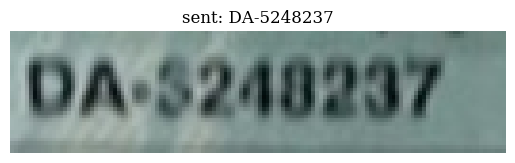

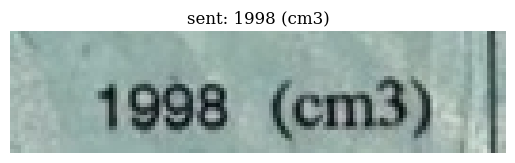

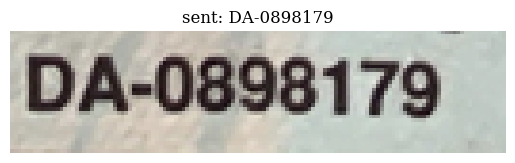

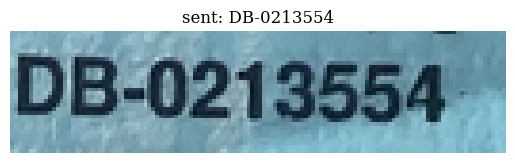

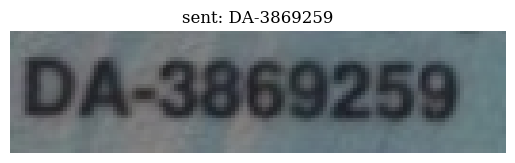

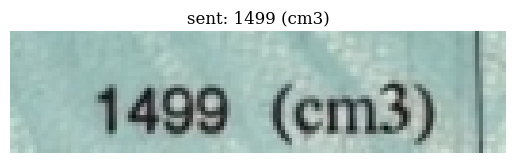

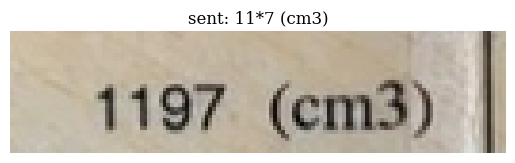

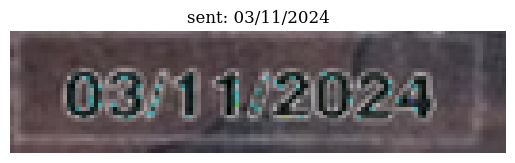

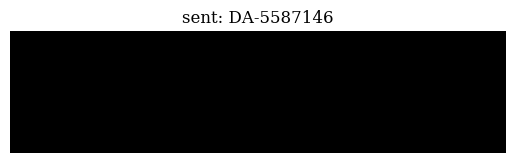

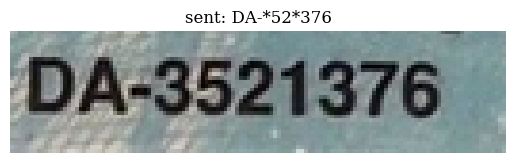

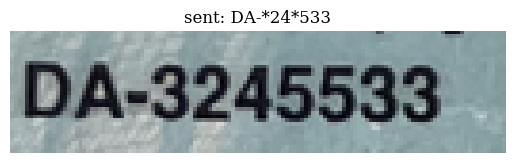

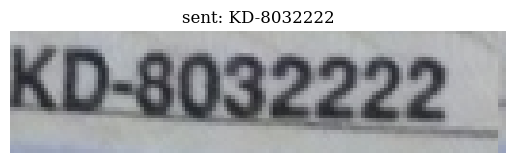

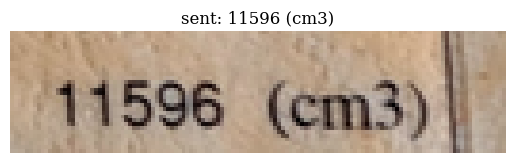

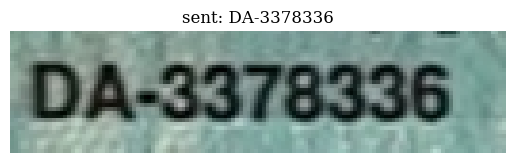

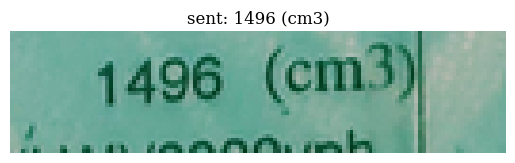

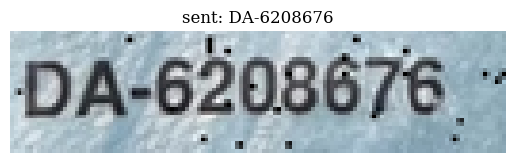

In [13]:
trainer.visualize_dataset()

Train now

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


iter: 000200 - train loss: 0.921 - lr: 1.91e-05 - load time: 3.92 - gpu time: 69.80
iter: 000400 - train loss: 0.783 - lr: 3.95e-05 - load time: 3.30 - gpu time: 66.96
iter: 000600 - train loss: 0.747 - lr: 7.14e-05 - load time: 3.39 - gpu time: 67.59
iter: 000800 - train loss: 0.724 - lr: 1.12e-04 - load time: 3.56 - gpu time: 65.65
iter: 001000 - train loss: 0.718 - lr: 1.56e-04 - load time: 3.67 - gpu time: 65.98
iter: 001200 - train loss: 0.720 - lr: 2.01e-04 - load time: 4.94 - gpu time: 65.69
iter: 001400 - train loss: 0.711 - lr: 2.41e-04 - load time: 4.78 - gpu time: 66.81
iter: 001600 - train loss: 0.713 - lr: 2.73e-04 - load time: 2.73 - gpu time: 64.43
iter: 001800 - train loss: 0.721 - lr: 2.93e-04 - load time: 4.33 - gpu time: 67.26
iter: 002000 - train loss: 0.723 - lr: 3.00e-04 - load time: 2.43 - gpu time: 68.27
iter: 002200 - train loss: 0.710 - lr: 3.00e-04 - load time: 4.05 - gpu time: 65.42
iter: 002400 - train loss: 0.703 - lr: 3.00e-04 - load time: 4.82 - gpu time

Visualize prediction from our trained model


In [ ]:
trainer.visualize_prediction()

Compute full seq accuracy for full valid dataset

In [ ]:
trainer.precision()